In [2]:
import pandas as pd
from IPython.display import Image, display, Math, Latex

# Exploration #
## Loading datasets ##
I used the read_h5ad() function from the scanpy package to load the datasets.
The number of observations and variables in the loaded datasets is summarized in the following table: 

In [3]:
pd.read_csv('res/shape_table.csv', index_col=0)

Number of observations  Number of variables
train dataset                   72208                 5000
test dataset                    18052                 5000

In the table below, I have presented the statistics for the loaded datasets.

In [4]:
pd.options.display.float_format = "{:,.2f}".format
pd.read_csv('res/stats_with_zeros.csv', index_col=0)

min           max  mean  median
preprocessed train data 0.00 21,078,940.00  3.43    0.00
raw train data          0.00     35,451.00  0.44    0.00
preprocessed test data  0.00 21,078,940.00  3.66    0.00
raw test data           0.00     35,451.00  0.45    0.00

## Histograms for raw and preprocessed data ##
Below I have presented the histograms for the loaded datasets. Given the very large difference between the maximum and minimum values in the preprocessed and raw data, and the low values of the mean and median, I decided to limit the x-axis on the histograms to increase their readability.

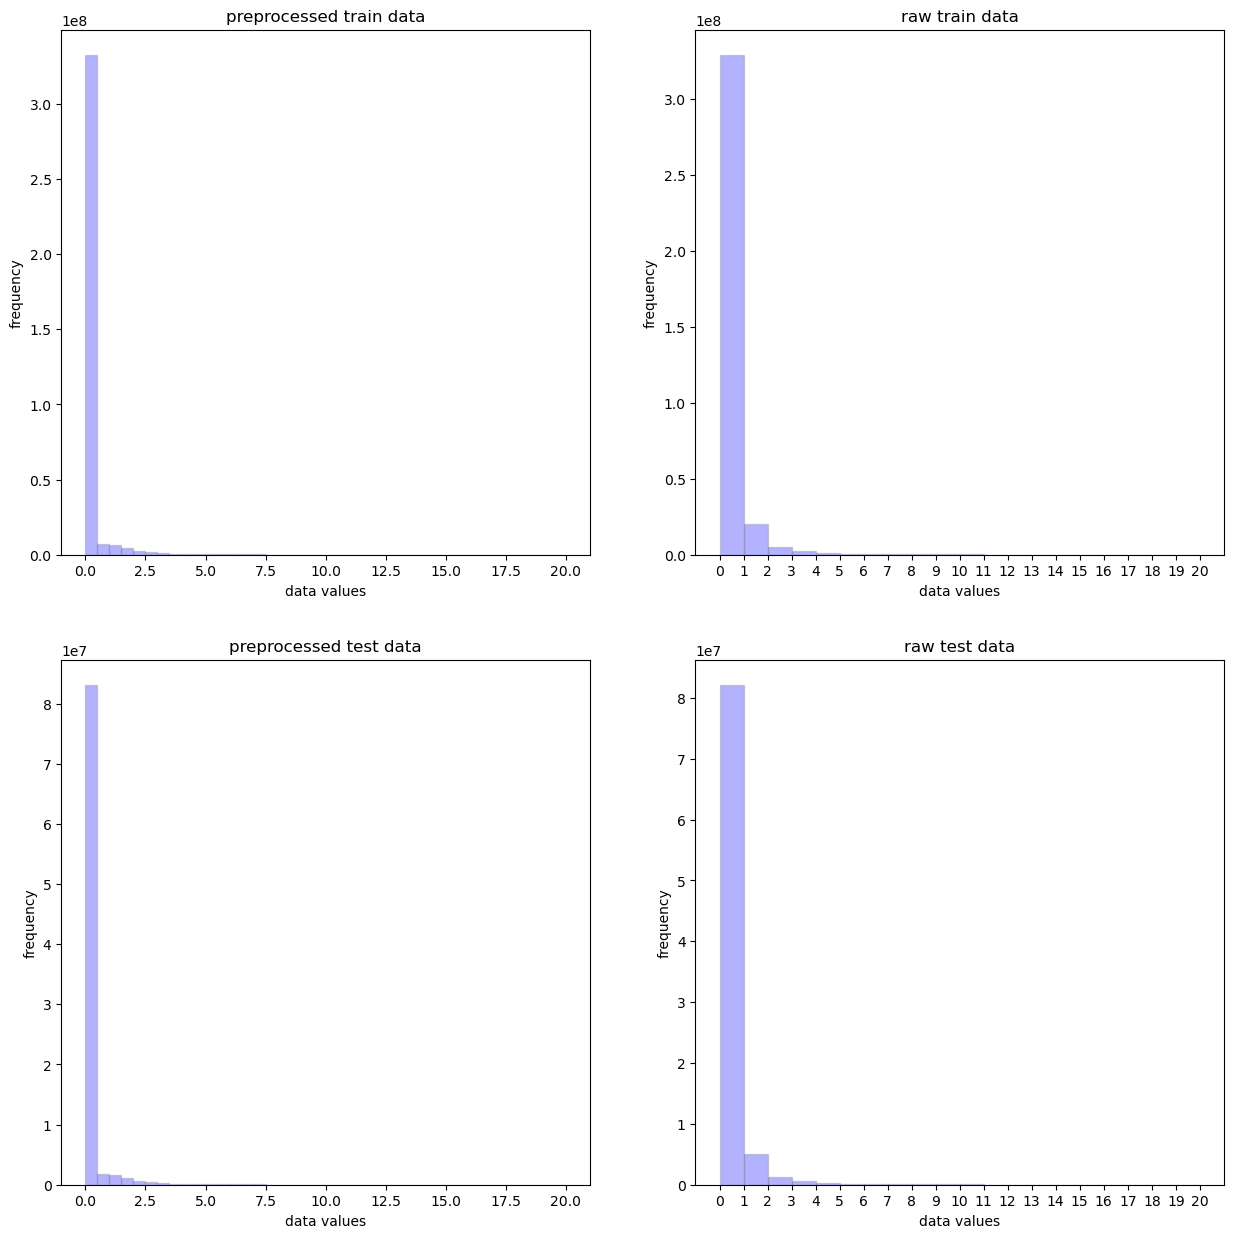

In [6]:
Image(filename='res/hists_with_zeros.png', width = 750, height = 750) 

## Proprocessing - explanation ##
For preprocessing, the raw data obtained for each cell were divided by the size factor (here GEX_size_factors given in the `adata.obs`), which are a cell-specific scaling factors. The size factor for each cell represents the estimate of the relative bias in that cell, so division of its counts by its size factor should remove that bias.

## Histograms for raw and preprocessed data after removing the zeros ##
The content of values other than zero is barely visible in the previous histograms due to the very high content of zeros in the analyzed data sets. In order to be able to look more closely at the content of values greater than 0 in the data, below I present histograms for datasets that do not contain zero values.


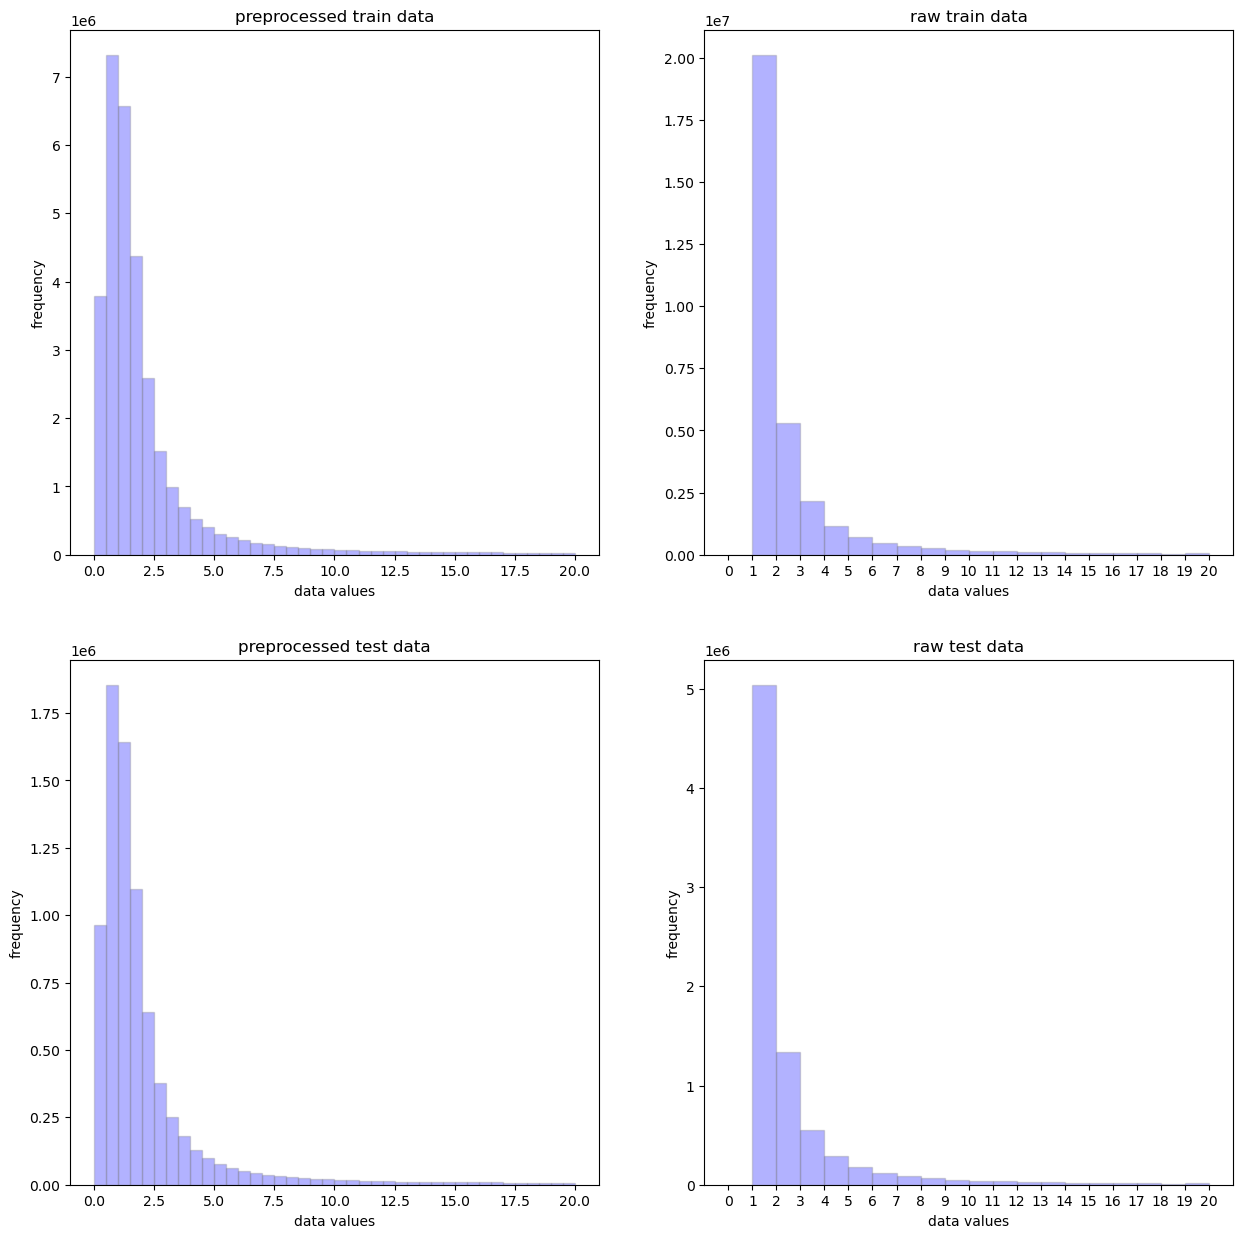

In [7]:
Image(filename='res/hists_without_zeros.png', width = 750, height = 750) 

## High content of zeros - explanation ##
Based on the histograms for the training and test data, it can be concluded that the data have an exponential distribution. This is particularly noticeable for the raw data. The incidence of zeros is much higher than the other values. We can divide zeros in scRNA data into biological zeros and non-biological zeros. Biological zero is defined as the true absence of expression of a particular gene. The high content of zeros is due to the fact that gene expression is a cell-specific process and in most cells for a large number of genes is low or absent. This means that in different cell types and under different conditions in the same cell type, the expression levels of different genes can vary significantly. In view of this, often a particular gene is expressed only in a particular cell type and under well-defined conditions, resulting in few observations in the data where expression of this gene was observed, i.e. the value is not 0. The second type of zeros found in sc-RNA data are non-biological zeros. They result from limitations of the method, such as imperfect mRNA capture efficiency in the reverse transcription from mRNA to cDNA during library-preparation steps before sequencing and a limited sequencing depth, which is determined by the experimental budget and sequencing machine.

## Data contained in `adata.obs` object ##
Object `adata.obs` contains metadata about the observations (i.e. cells). In this DataFrame we can find additional information about each observation. In our case, this object contains columns with information such as: size factors for individual cell, cell type, batch, site, donor ID, donor age, donor blood type or donor gender.
Based on this DataFrame, I determined the number of patients and laboratories involved in the experiment, as well as the number of cell types in the data. I presented this information in the table below.

In [7]:
pd.read_csv('res/info_table.csv', index_col=0)

Number of patients  Number of labs  Number of cell types
train dataset                   9               4                    45
test dataset                    9               4                    45

# Vanilla VAE training #
The VAE Vanilla model is built with a stochastic Encoder and Decoder. In both modules, I used fully-connected linear layers with one hidden layer. The input to the Encoder are observations from the gene expression matrix for raw data. In Encoder model learns the parameters of the multivariate normal distribution, from which it then samples the hidden space, which is the output. The output of the Encoder is the input of the Decoder. Based on the latent space, the model in the Decoder learns the parameters of the multivariate distribution, which constitute the output of this module. VAE Vanilla is trained with a probabilistic loss - negative ELBO, which includes: Kullback–Leibler divergence (measured between the standard noraml distribution and the distribution obtained in Encoder) and reconstruction loss (logarithm of the probability of seeing data under p(x|z); calculated in Decoder).

## Model training ##
In order to keep the calculations numerically stable, it was necessary to scale the data to the 0-1 range. To do this, I used the formula (x-min)/(max-min), and since min=0 this scaling came down to dividing the resulting raw data sets by their maximum values.

The model was trained on full data (s=1.0).
Model parameters used:

* latent_dim: 100
* hidden_dim: 250
* learning_rate: 0.0005
* batch_size: 32
* beta: 1.0
* epochs: 20

A description of the model's parameters can be found in the README file.

Below are the learning curves received for both training and test sets. In addition to the plot for the loss function (negative ELBO), I broke negative ELBO into regularization (Dkl) and reconstruction losses and plotted them accordingly.

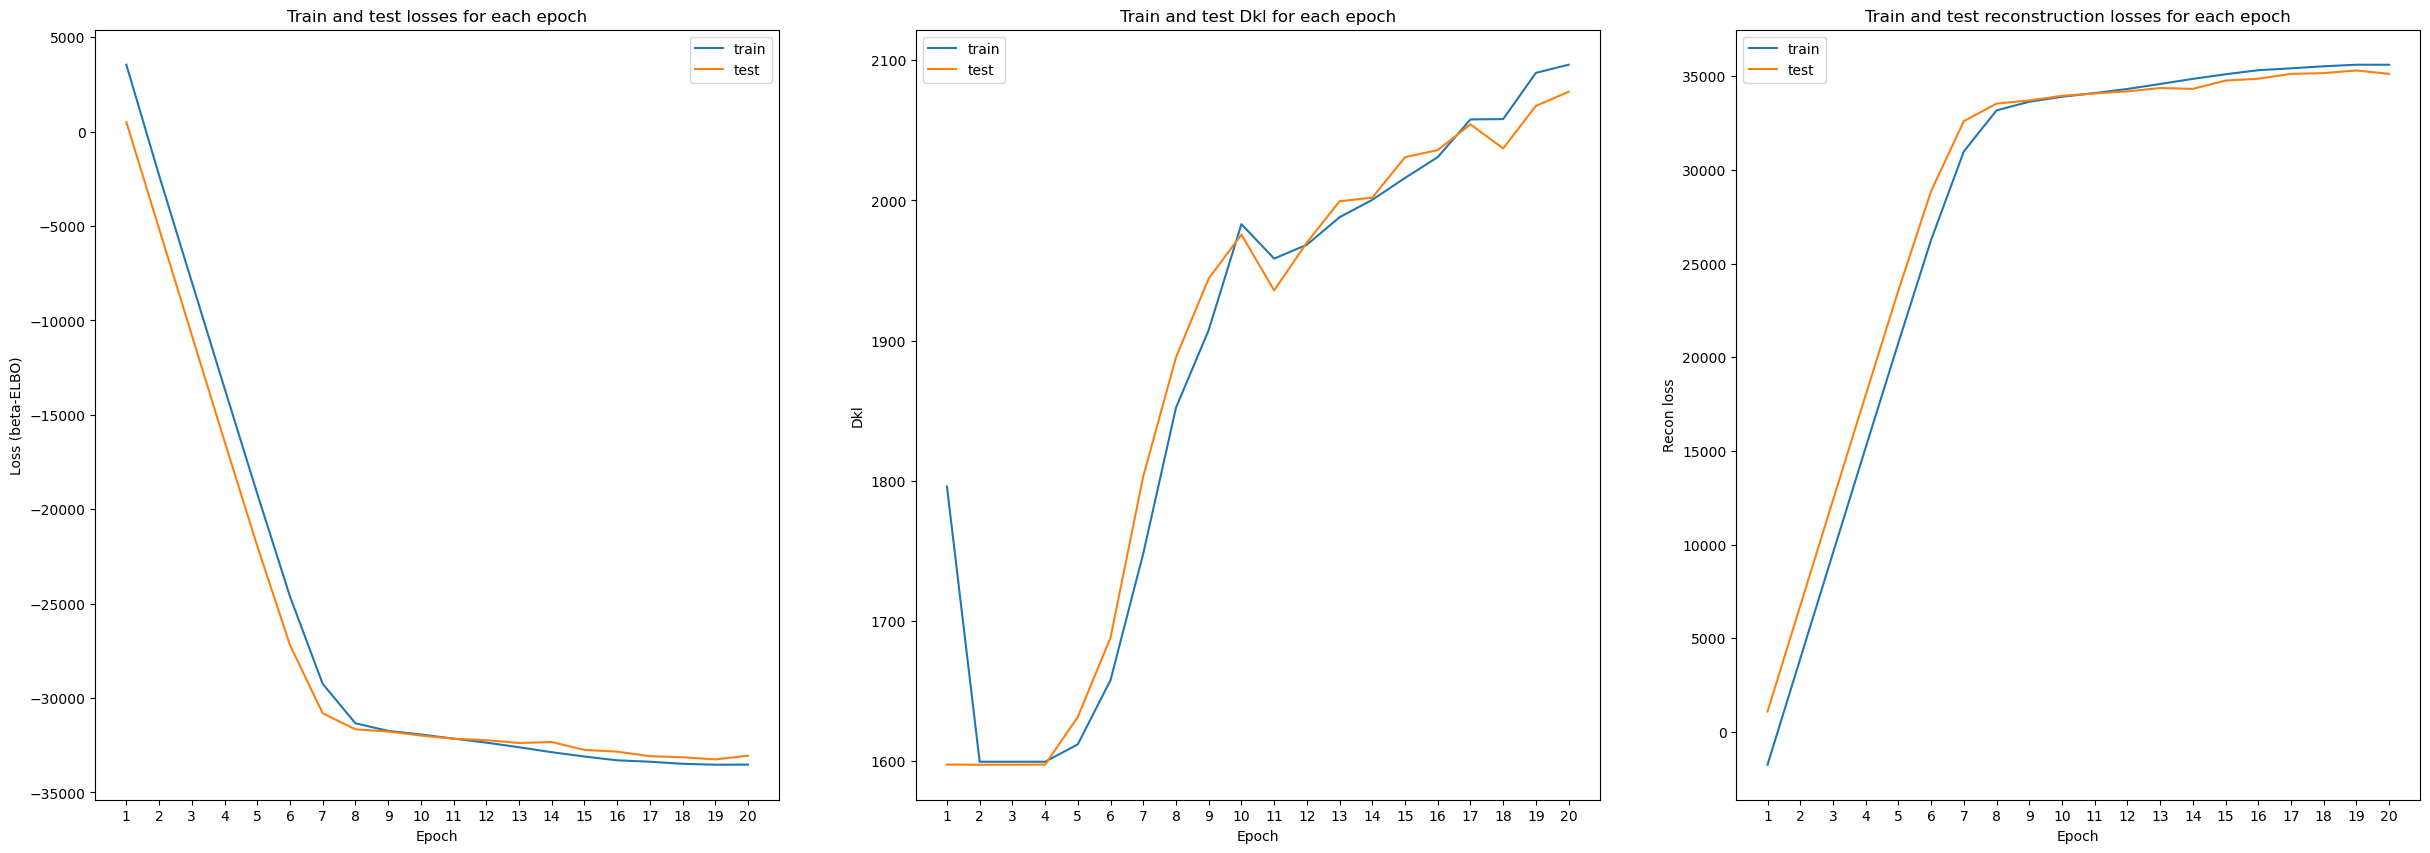

In [21]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld100_hd250_bs32_epo20.png', width = 1500, height = 500) 

The presented curves allow verification of the model's learning procedure. As expected, negative-ELBO decreases and converges, both on the training set and the test set. The curves for the reconstitution component look similar, but in this case we see increase and convergence, which is also as expected. Only the course of the Dkl curves is unusual - initially the curve for the training set decreases (as expected), but then we observe an increase of the curves (for both the training and test sets). Despite this unusual behavior, the regularization component does not disturb the curve for negative-ELBO, since the increase in Dkl is relatively small compared to the reconstruction component. Thus it can be concluded that the training of the model went well, since the most important element is the loss function (negative-ELBO), and this decreases and converges.

To check the impact of the size of the latent space on learning the model, I also trained model training for other values of the latent_space parameter - greater (500) and lesser (50) than the previous one. The obtained curves are presented below.

* latent_dim: 500

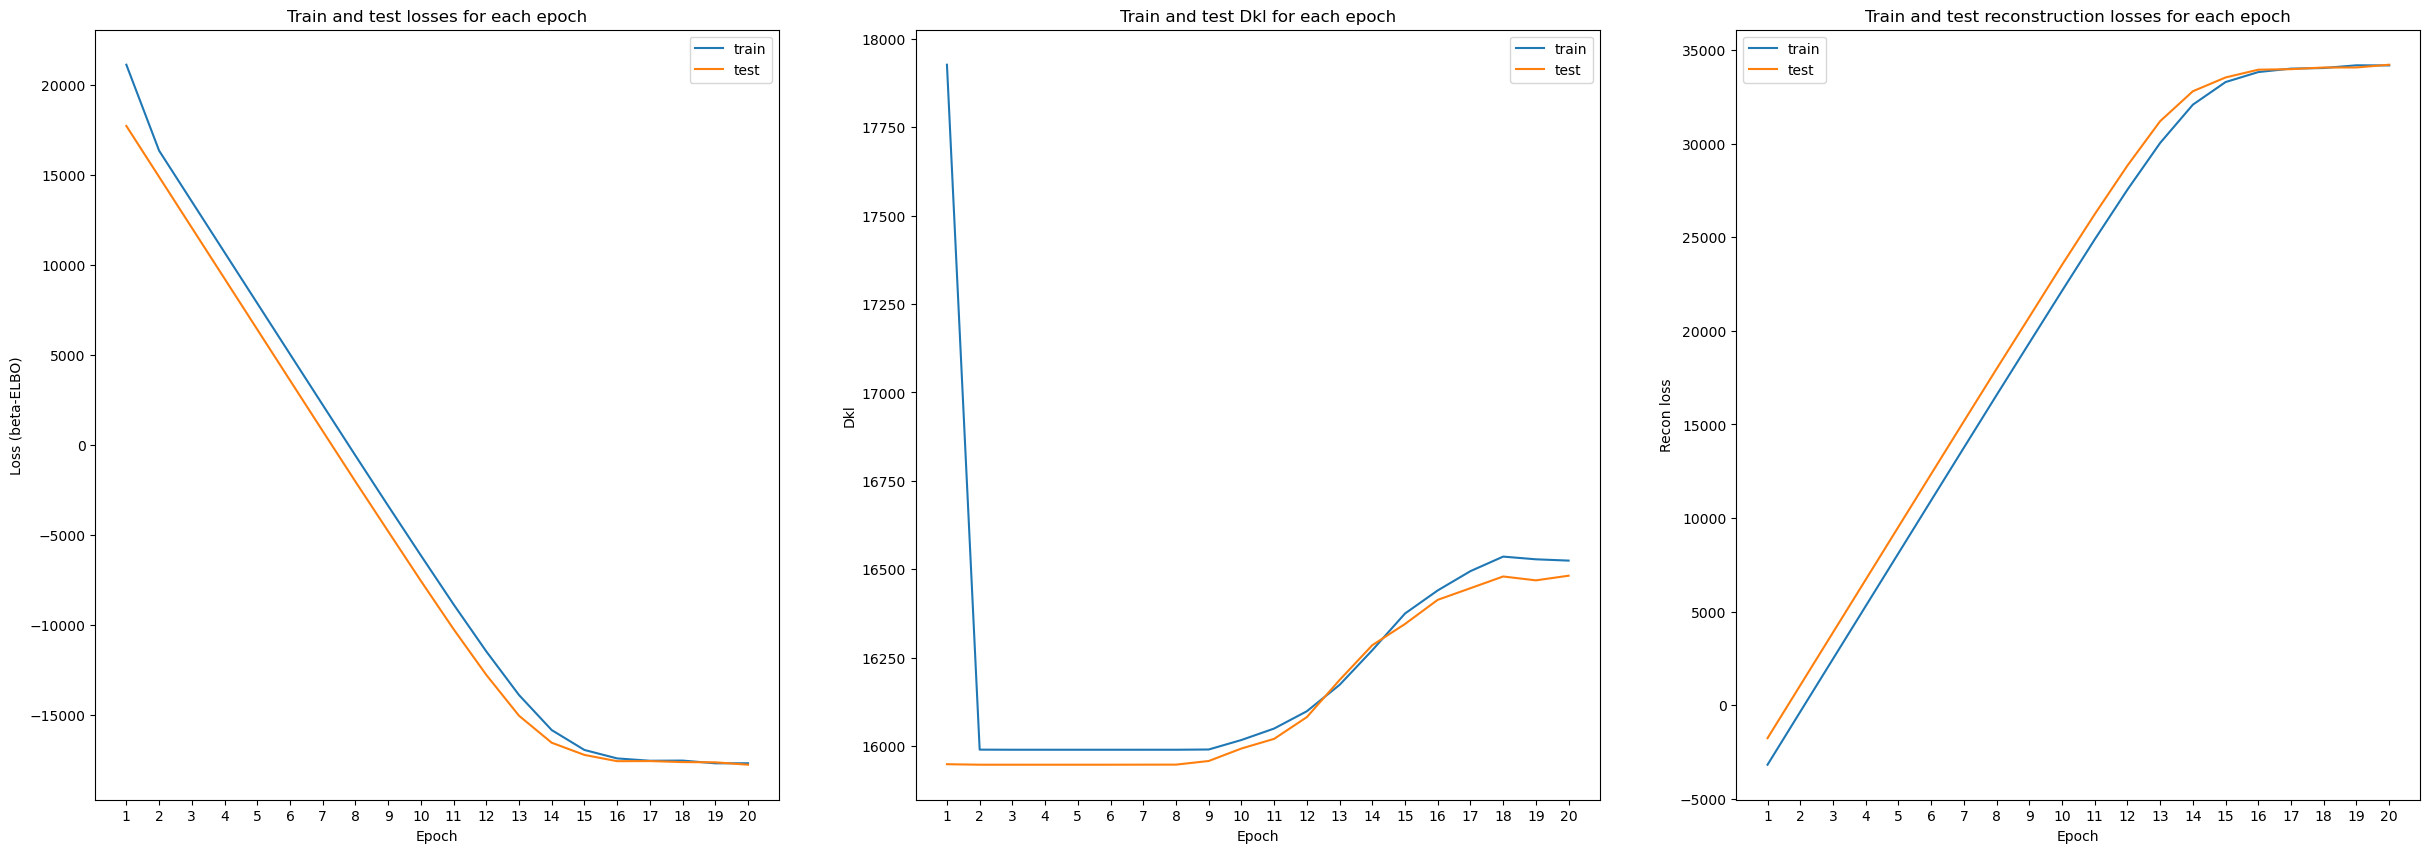

In [22]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld500_hd1000_bs64_epo20.png', width = 1500, height = 500) 

In [74]:
display(Latex(f"\\newpage"))

<IPython.core.display.Latex object>

* latent_dim: 50

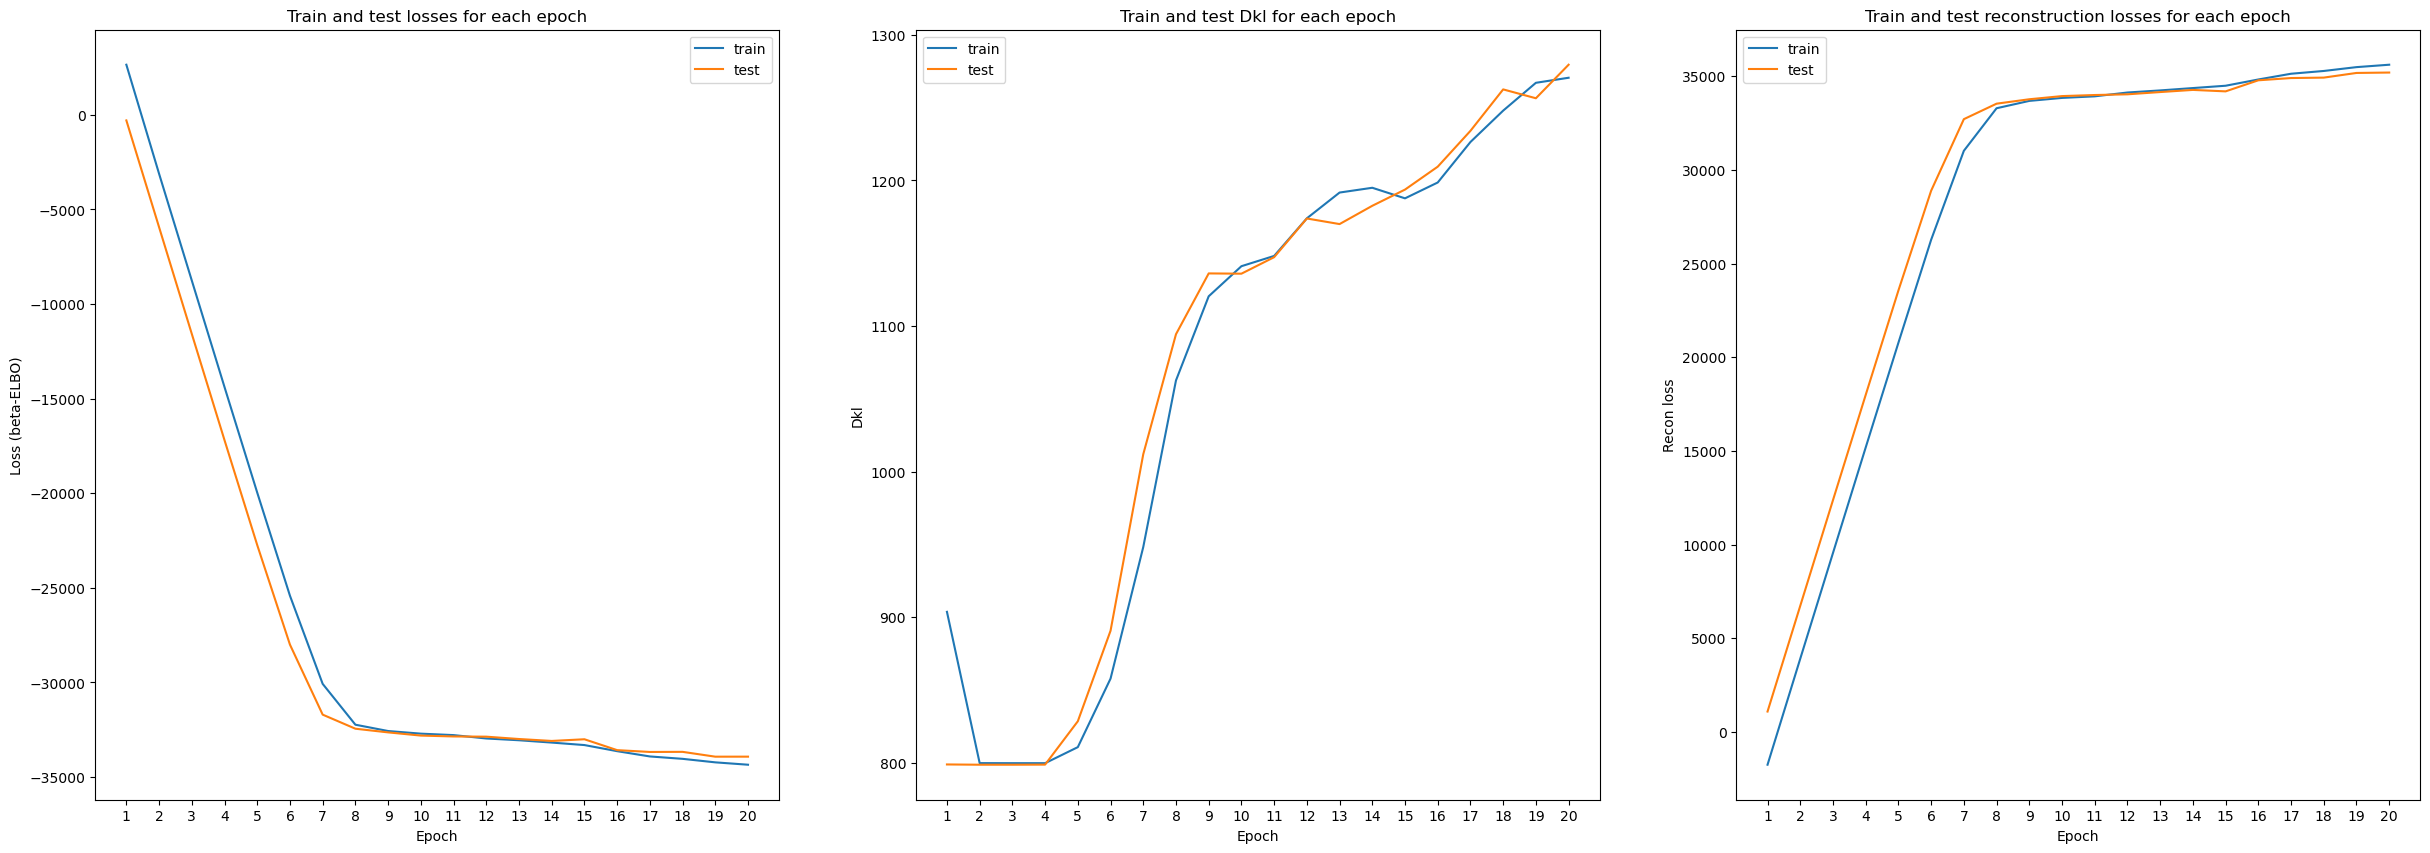

In [23]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld50_hd250_bs32_epo20.png', width = 1500, height = 500) 

## Latent space analysis using PCA ##
For all 3 models, I fitted PCA to the latent space obtained for the test set. In the table below, I summarized the negative ELBO, Dkl and reconstruction loss values obtained on the test set for each model. In the table, I also included information about the number of principal components explaining 95% of the variance (column PCA_cell_type) and what percentage of the size of the latent space the resulting number represents.

In [40]:
pd.options.display.float_format = "{:,.2f}".format
l1 = pd.read_csv('res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld50_hd250_bs32_epo20_stats.csv')
l2 = pd.read_csv('res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld100_hd250_bs32_epo20_stats.csv')
l3 = pd.read_csv('res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld500_hd1000_bs64_epo20_stats.csv')
df = pd.concat([l1, l2, l3], axis=0, ignore_index=True)
df['percentage_of_ldim[%]'] = df['PCA_cell_type'] / df['l_dim'] * 100
df[['-ELBO', 'Dkl', 'Recon', 'PCA_cell_type', 'l_dim', 'percentage_of_ldim[%]']]

-ELBO       Dkl     Recon  PCA_cell_type  l_dim  percentage_of_ldim[%]
0 -33,969.78  1,279.45 35,249.24             47     50                  94.00
1 -33,133.97  2,077.51 35,211.48             93    100                  93.00
2 -17,785.66 16,481.66 34,267.32            467    500                  93.40

The figures below show the scatterplots for the first two principal components for each model, where each point is colored with adata.obs.cell_type.

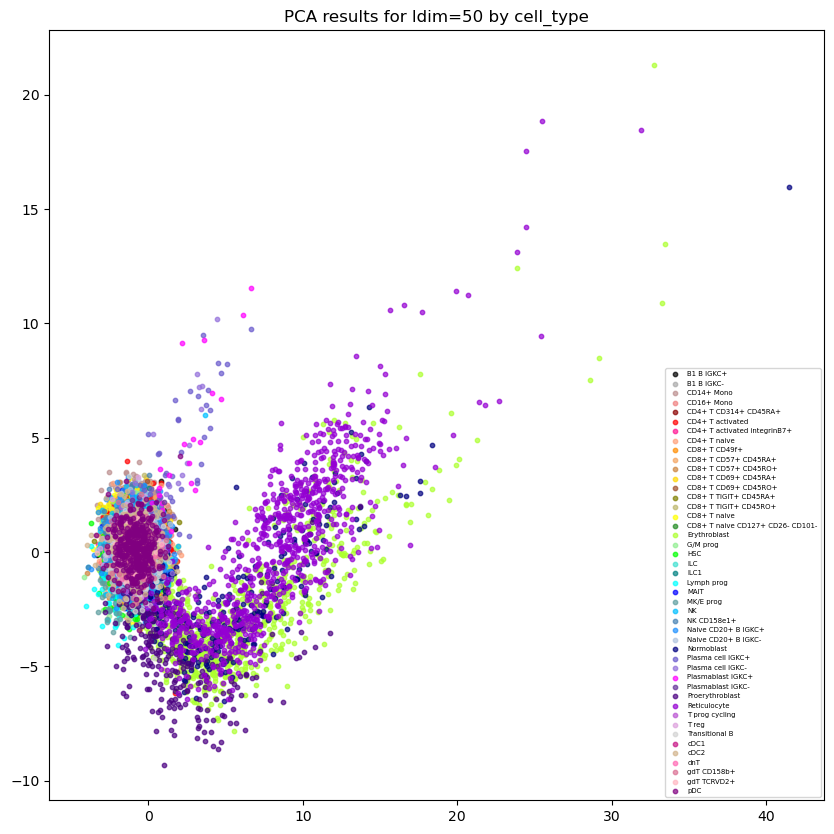

In [44]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld50_hd250_bs32_epo20_PCA_cell_type.png', width = 750, height = 750) 

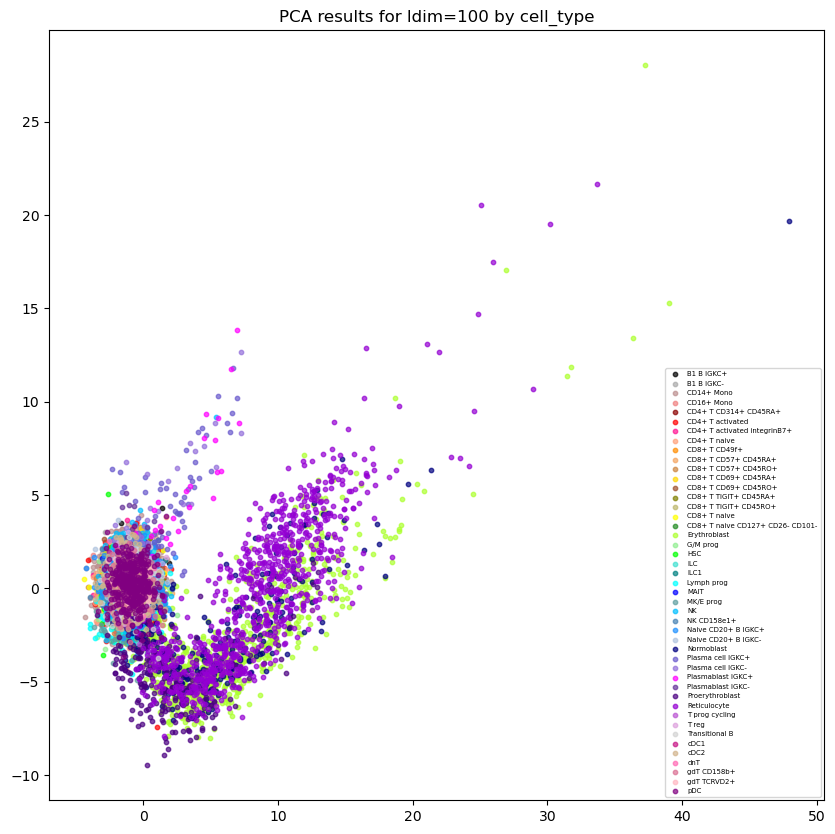

In [45]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld100_hd250_bs32_epo20_PCA_cell_type.png', width = 750, height = 750) 

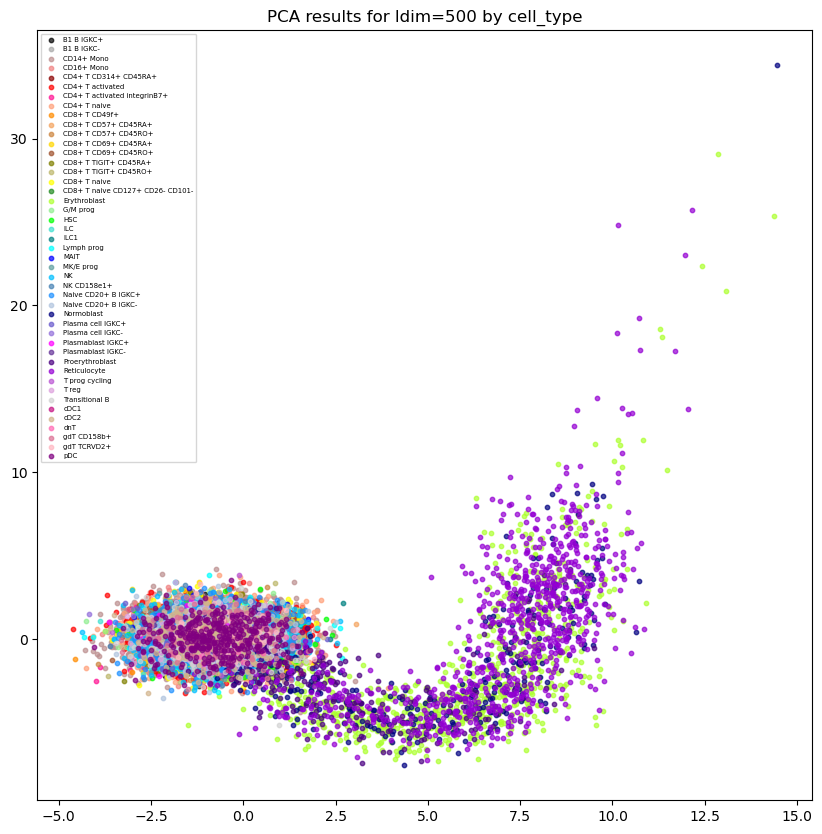

In [67]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld500_hd1000_bs64_epo20_PCA_cell_type.png', width = 750, height = 750) 

PCA analyses for all models came out comparably. In each case, about 93-94% of the principal components explained 95% of the variance. The scatterplots shown for the first two principal components are also similar for all 3 latent space sizes. We can see on them that the cells of the 3 types were distinguished from the other cell types, but no cell type stands out singly. 

## Conclusions ##
The model with the worst performance turned out to be the one for latent space size equal to 500, due to the fact of the high negative ELBO value - about two times higher than in the other two cases. The models for latent space sizes 50 and 100 are very similar, in terms of both negative ELBO values and variance explainability. In the end, I decided to choose the model for a latent space size of 100, because it explains the variance contained in the latent space slightly better, which may indicate that by reducing the latent space even more, we lose some relevant information. 

To train and test the final models, I decided to choose raw data. Based on the histograms, the raw data appear to have a distribution more similar to the exponential distribution (which I use in the next part of the task) than the preprocessed data. In addition, the raw data has a smaller spread between the minimum and maximum values, which can make it easier to train the model. To be sure of my choice, I also trained models on preprocessed data, but did not obtain any combination of architecture and model parameters that gave better performance than models trained on the raw data. For the preprocessed data, the loss function fluctuated strongly during training, the final negative ELBO was significantly higher than for the raw data and the PCA results were also worse. 

# Custom Decoder #
## Exponencial Decoder ##
Below I have included the code fragments of the new model changed compared to Vanilla VAE and the corresponding code fragments of Vanilla VAE. If "..." appears in the new version, it means that this part of code is identical to that in Vanilla VAE.

The main modification I made was to change the distribution used to calculate the reconstruction loss in Decoder. I changed the multivariate normal distribution to an exponential distribution with a single parameter - `rate`. I decided to choose an exponential distribution because, based on the histograms presented earlier, such a distribution seems to well represent the actual distribution of the raw data. In addition, it may have a biological justification - due to cell-specific gene expression (explained earlier), in most cells the expression of most genes does not occur or occurs at a low level, so the probability of observing low values in the data should be much higher than the probability of observing large values, which is what the exponential distribution provides us with. I have included the code of changed functions below.

In [ ]:
# DecoderGaussian in Vanilla VAE:
class DecoderGaussian(nn.Module):
    def __init__(self, decoder: DecoderNN):
        super(DecoderGaussian, self).__init__()
        self.decoder = decoder
        self.log_variance = nn.Parameter(torch.Tensor([0.0]))
    
    def log_prob_xz(self, mean, log_variance, x):
        x = torch.flatten(x, start_dim=1)
        variance = torch.exp(log_variance)
        dist = distributions.Normal(mean, variance)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1))
    
    def forward(self, z, x) -> tuple():
        out = self.decoder(z)
        recon_loss = self.log_prob_xz(out, self.log_variance, x)
        return out, recon_loss



# Changed DecoderGaussian
class DecoderGaussian_custom(nn.Module):
    def __init__(self, decoder: DecoderNN_custom):
        super(DecoderGaussian_custom, self).__init__()
        self.decoder = decoder

    def log_prob_xz(self, rate, x):
        x = torch.flatten(x, start_dim=1)
        dist = distributions.exponential.Exponential(rate)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1))
     
    def forward(self, z,  x) -> tuple():
        rate = self.decoder(z)
        recon_loss = self.log_prob_xz(rate, x)
        return rate, recon_loss

Due to the fact that exponencial distribution has 1 parameter, which can only take positive values, it was necessary to change the architecture of the Decoder. I tested different configurations of the architecture (different number of layers, different activation functions) and finally the best option turned out to be the one below.

In [ ]:
# DecoderNN in Vanilla VAE
class DecoderNN(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, hidden_dim: int):
        super(DecoderNN, self).__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z):
        out = F.relu(self.linear1(z))
        out = torch.sigmoid(self.linear2(out))
        return out

# Changed DecoderNN
class DecoderNN_custom(nn.Module):
    ...
    def forward(self, z):
        out = F.relu(self.linear1(z))
        rate = F.relu(self.linear2(out)) + 1e-6
        return rate

In addition, I also checked various architectures in the Encoder to find the one that works best with the new Decoder. I made a small change, regarding the function applied to the last layer for the parameter corresponding to the variance. Changed function is showed below. Other elements of the model remained the same as in Vanilla VAE.

In [ ]:
# EncoderNN in Vanilla VAE:
class EncoderNN(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, hidden_dim: int):
        super(EncoderNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, latent_dim)
        self.linear3 = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x) -> tuple():
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        return mu, sigma
        
# Changed EncoderNN
class EncoderNN_custom(nn.Module):
    ...
    def forward(self, x) -> tuple():
        out = F.relu(self.linear1(x))
        mu =  self.linear2(out)
        sigma = F.relu(self.linear3(out)) + 1e-6
        return mu, sigma

## Model training ##
Again, I trained three models for different sizes of latent space: 50, 100 and 500.
The models was trained on full scaled data (s=1.0).
Model parameters used:

* latent_dim: 50 / 100 / 500
* hidden_dim: 100 / 250 / 750
* learning_rate: 0.005 / 0.008 / 0.005
* batch_size: 32
* beta: 1.0
* epochs: 20

In [75]:
display(Latex(f"\\newpage"))

<IPython.core.display.Latex object>

Below are the learning curves (-ELBO, Dkl and recon loss) received for both training and test sets.

* latent_space: 50

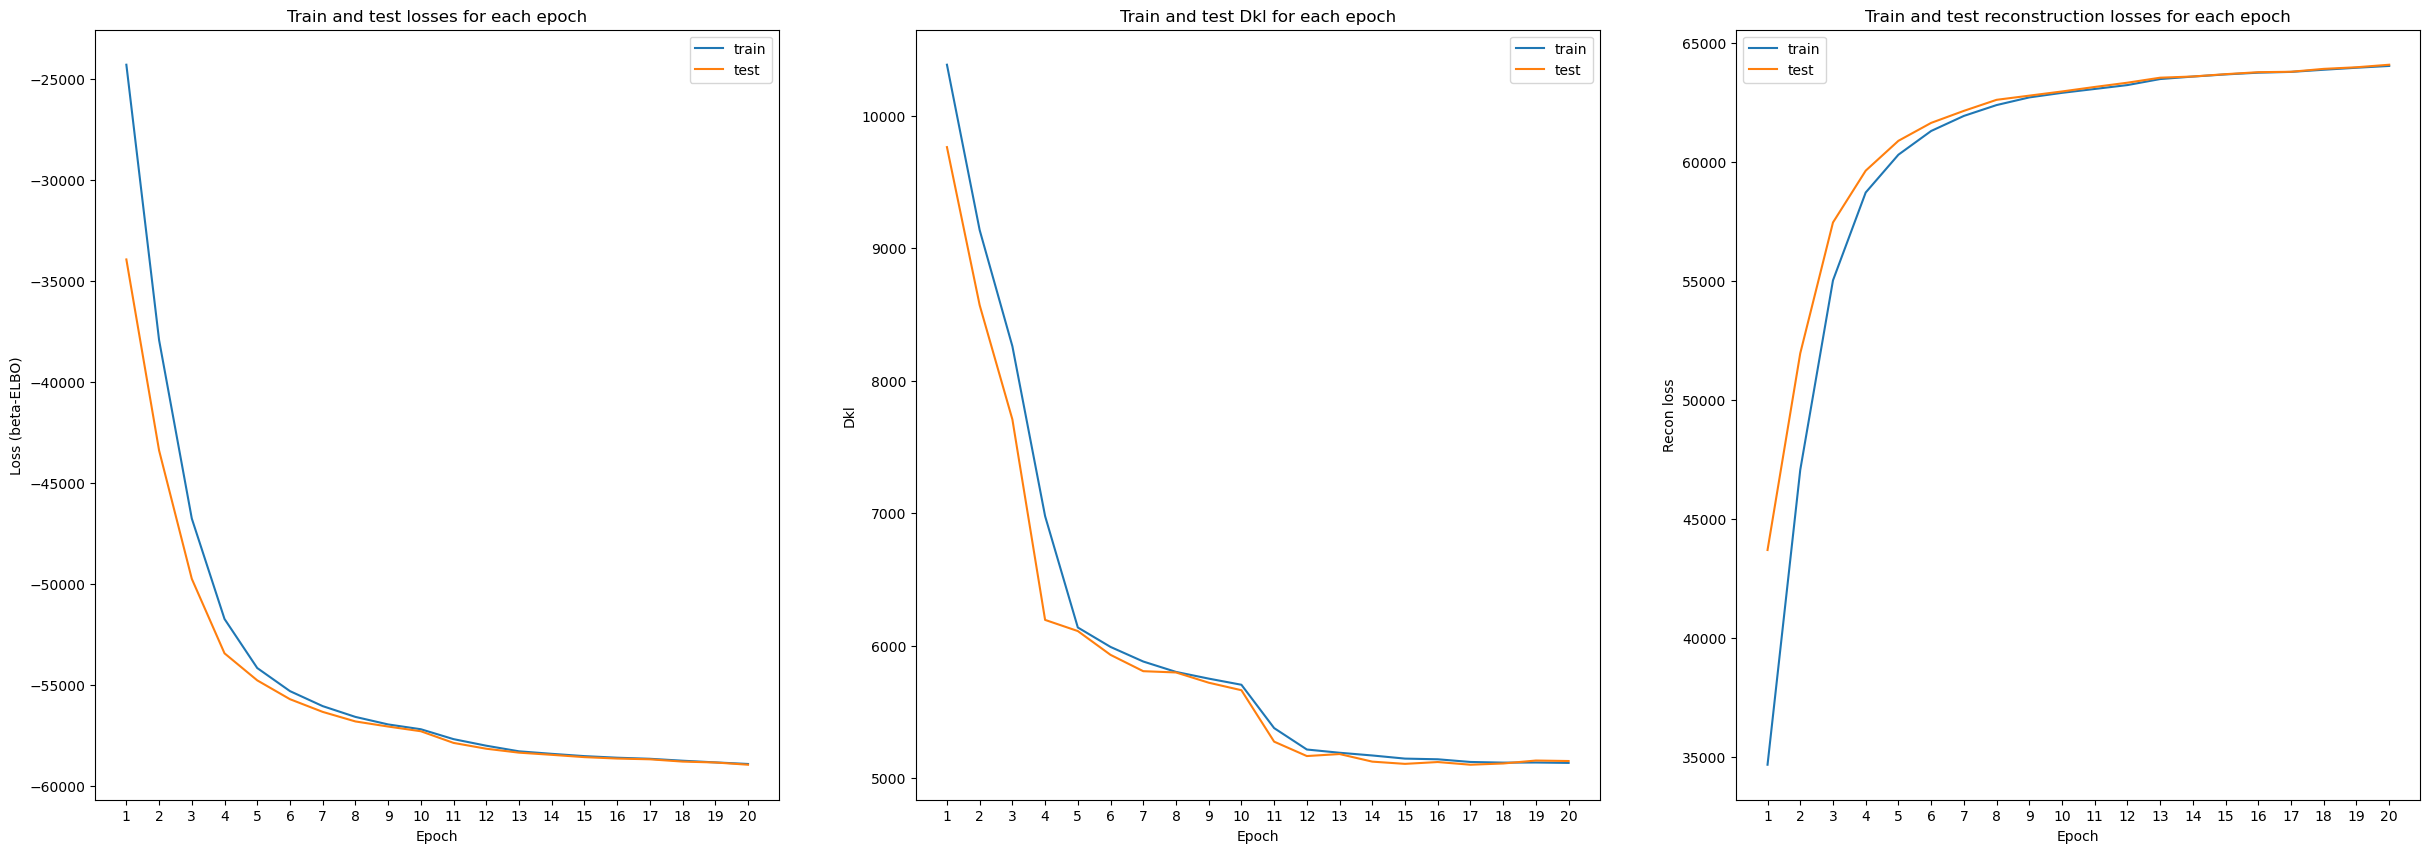

In [48]:
Image(filename='res/custom_decoder/vae_exp_s1.0_b1.0_lr0.005_ld50_hd100_bs32_epo20.png', width = 1500, height = 500) 

* latent_space: 100

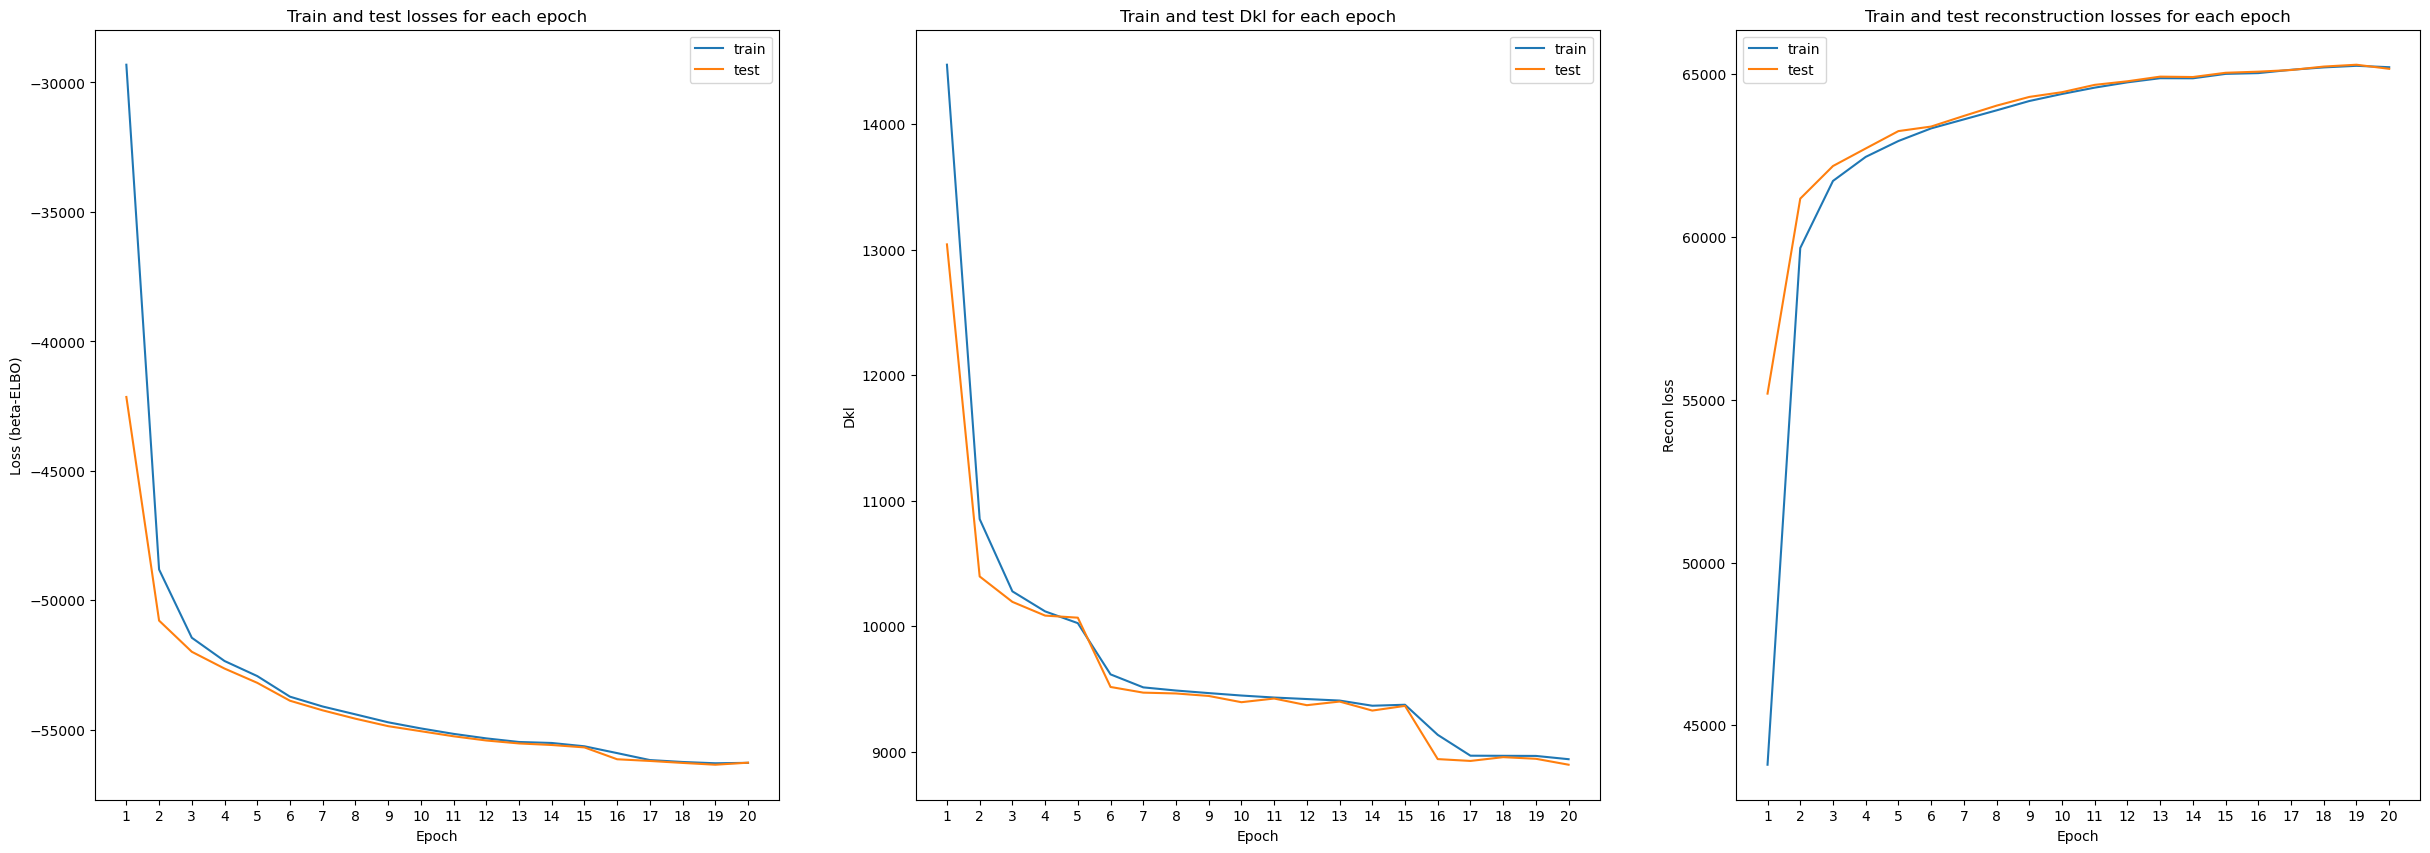

In [47]:
Image(filename='res/custom_decoder/vae_exp_s1.0_b1.0_lr0.008_ld100_hd250_bs32_epo20.png', width = 1500, height = 500) 

* latent_space: 500

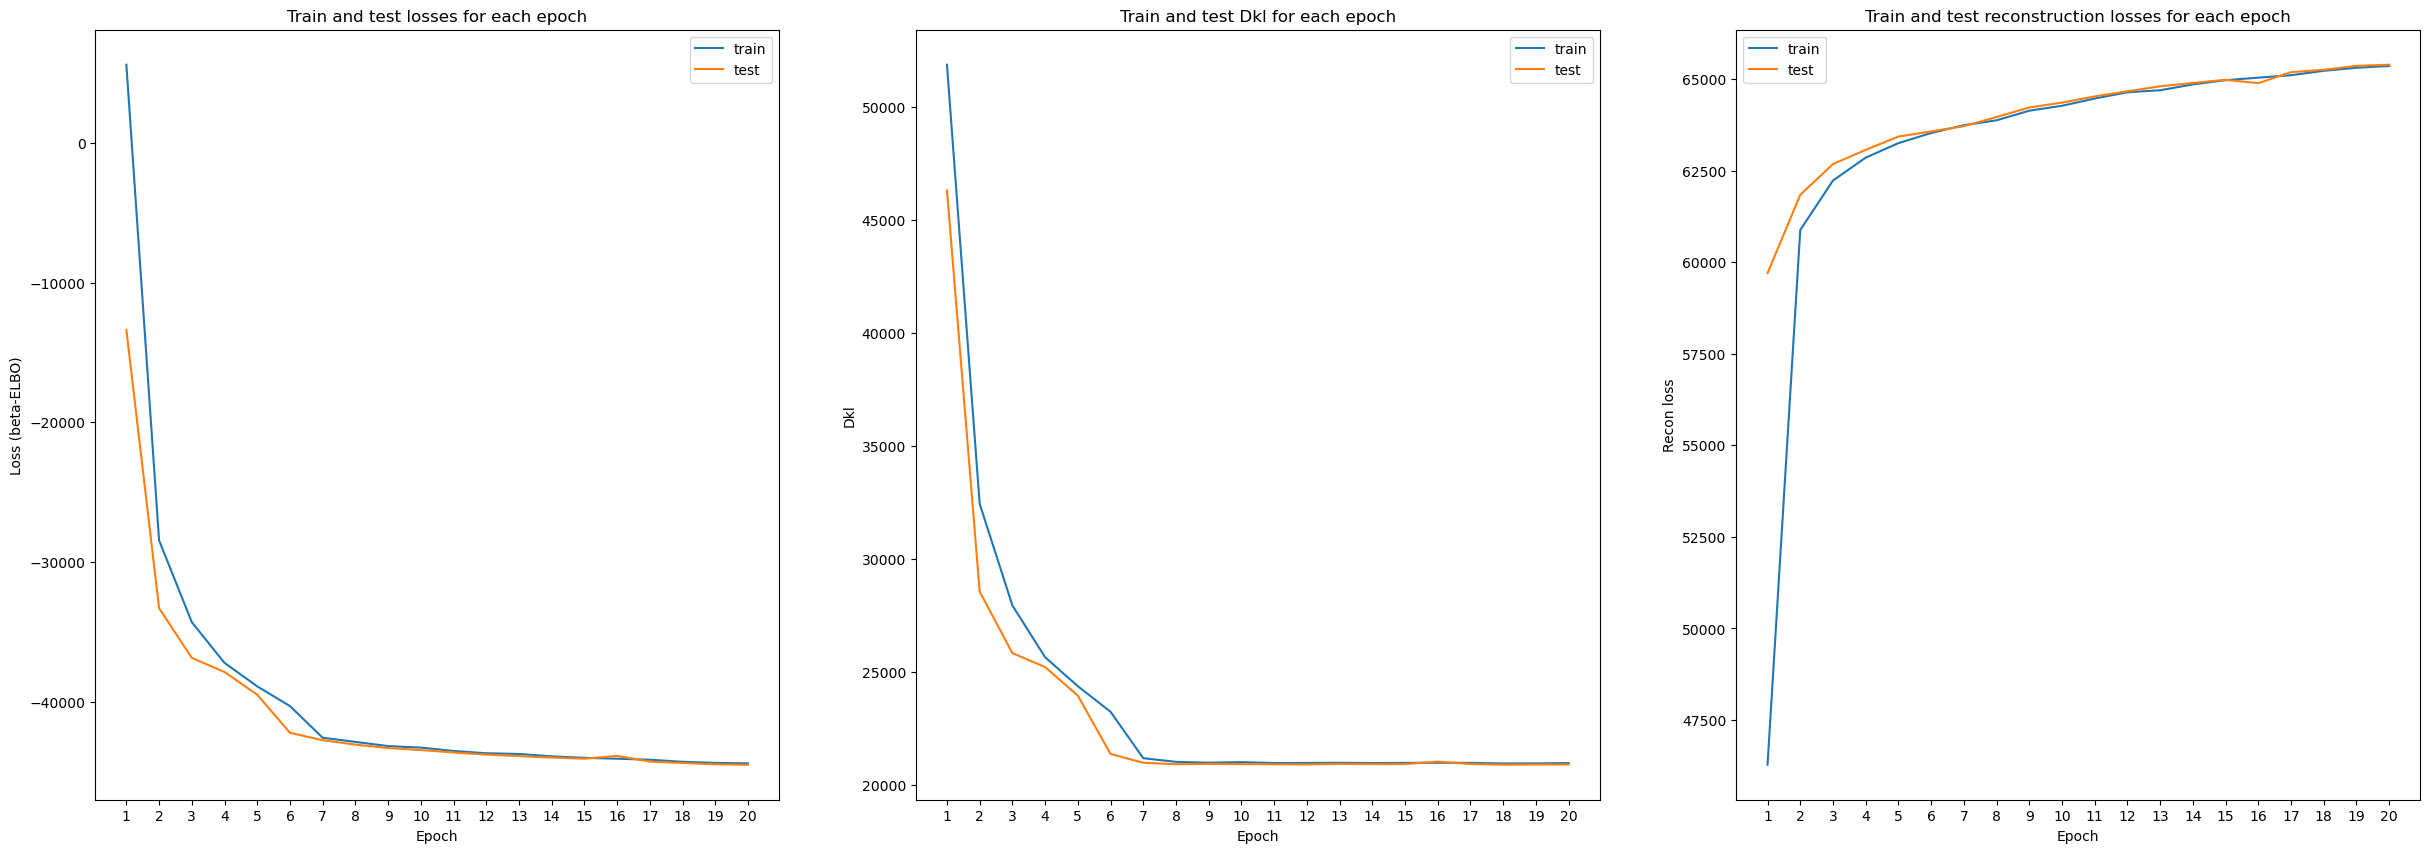

In [49]:
Image(filename='res/custom_decoder/vae_exp_s1.0_b1.0_lr0.005_ld500_hd750_bs32_epo20.png', width = 1500, height = 500) 

Based on the above curves, we can conclude that all 3 models fitted well. For each model, all 3 curves (loss function, Dkl, recon loss) have a course as expected. Negative ELBO and Dkl decrease and converge, while reconstruction loss increases and converges. We also do not observe large fluctuations during learning.

Analogous to the Vanilla VAE, I fit PCA to the latent spaces and summarized the final results obtained on the test dataset for all 3 models in the table below.

In [53]:
pd.options.display.float_format = "{:,.2f}".format
l1 = pd.read_csv('res/custom_decoder/vae_exp_s1.0_b1.0_lr0.005_ld50_hd100_bs32_epo20_stats.csv')
l2 = pd.read_csv('res/custom_decoder/vae_exp_s1.0_b1.0_lr0.008_ld100_hd250_bs32_epo20_stats.csv')
l3 = pd.read_csv('res/custom_decoder/vae_exp_s1.0_b1.0_lr0.005_ld500_hd750_bs32_epo20_stats.csv')
df = pd.concat([l1, l2, l3], axis=0, ignore_index=True)
df['percentage_of_ldim[%]'] = df['PCA_cell_type'] / df['l_dim'] * 100
df[['-ELBO', 'Dkl', 'Recon', 'PCA_cell_type', 'l_dim', 'percentage_of_ldim[%]']]

-ELBO       Dkl     Recon  PCA_cell_type  l_dim  percentage_of_ldim[%]
0 -58,964.75  5,128.89 64,093.69             39     50                  78.00
1 -56,262.08  8,897.69 65,159.75             79    100                  79.00
2 -44,501.22 20,887.76 65,389.00            433    500                  86.60

Again, the worst performance was achieved by the model for latent space size 500 - the negative ELBO has a higher value than the other two models and the percentage of principal components explaining 95% of the variance is significantly higher than for the other two models. In this case, the model for latent space size 50 turned out to has the best performance - it achieved the lowest negative ELBO and required the lowest percentage of principal components to explain 95% of the variance (although the differences between sizes 50 and 10 were not large). In view of this, as a final model, I chose a model for latent space size equal to 50.

## Vanilla VAE vs VAE with Exponencial Decoder ##
To compare the performance of the final Vanilla VAE model with the final VAE with Exponencial Decoder model, I have again included the learning curves of both models below. Additionally, I summarized the final results obtained on the test dataset for for these two models in the table.

* Vanilla VAE

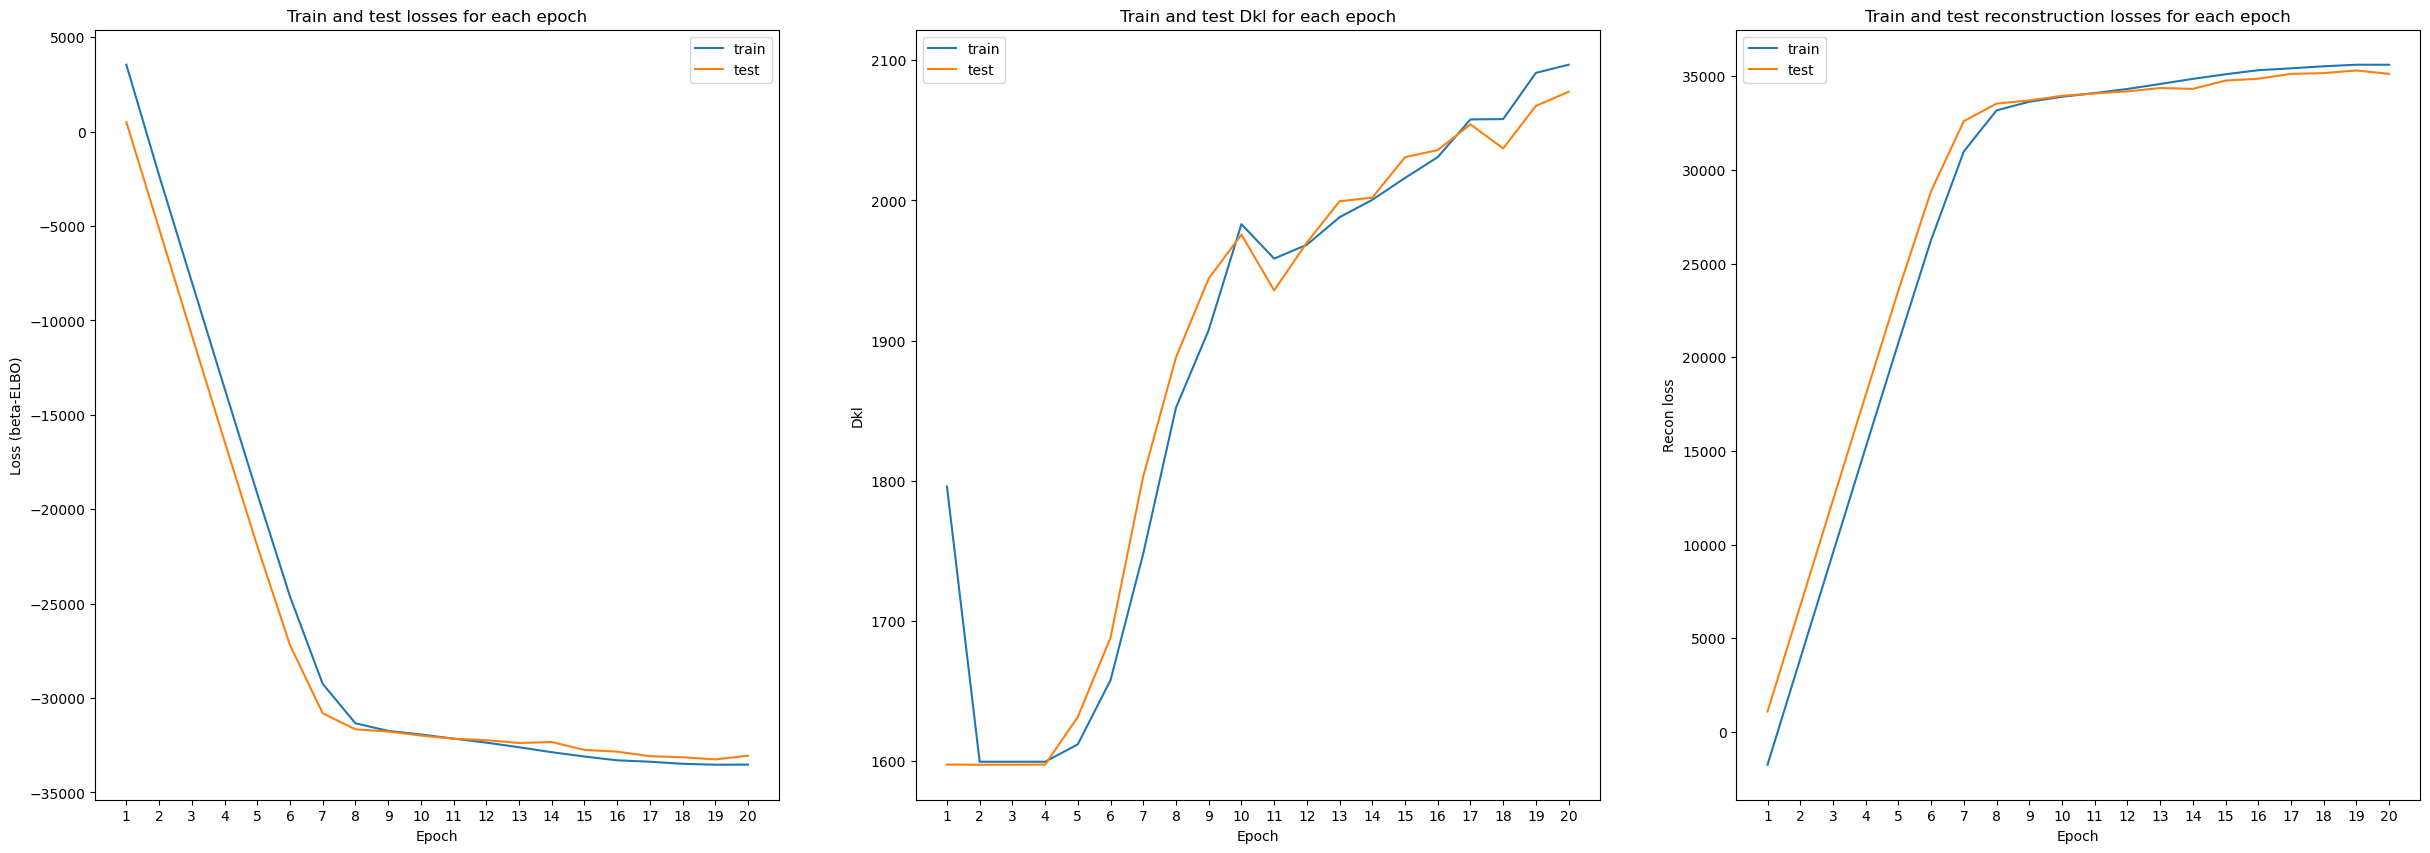

In [57]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld100_hd250_bs32_epo20.png', width = 1500, height = 500) 

In [76]:
display(Latex(f"\\newpage"))

<IPython.core.display.Latex object>

* VAE with Exponencial Decoder

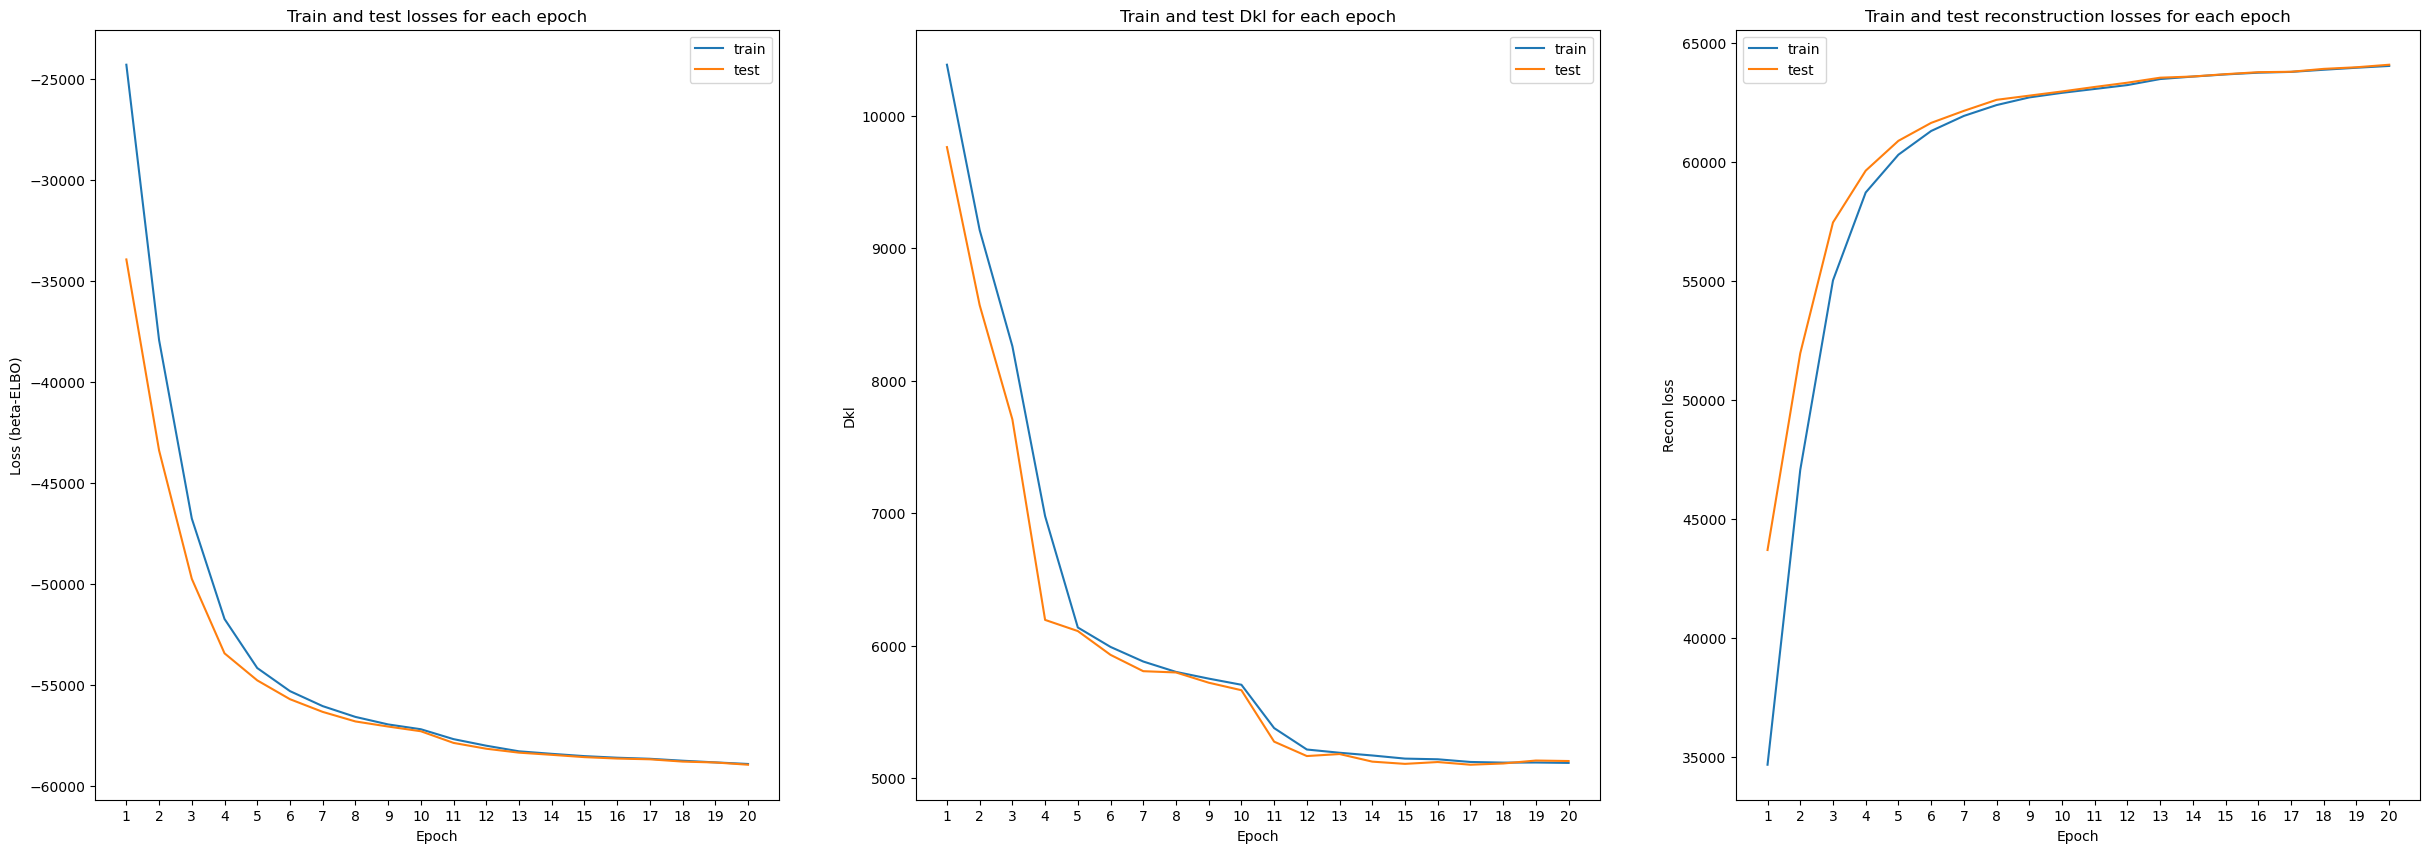

In [58]:
Image(filename='res/custom_decoder/vae_exp_s1.0_b1.0_lr0.005_ld50_hd100_bs32_epo20.png', width = 1500, height = 500) 

In [71]:
pd.options.display.float_format = "{:,.2f}".format
exp = pd.read_csv('res/custom_decoder/vae_exp_s1.0_b1.0_lr0.005_ld50_hd100_bs32_epo20_stats.csv')
van = pd.read_csv('res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld100_hd250_bs32_epo20_stats.csv')
exp['model'] = 'custom VAE'
van['model'] = 'Vanilla VAE'
df = pd.concat([exp, van], axis=0, ignore_index=True)
df['%_of_ldim'] = df['PCA_cell_type'] / df['l_dim'] * 100
df[['-ELBO', 'Dkl', 'Recon', 'PCA_cell_type', 'l_dim', '%_of_ldim', 'model']]

-ELBO      Dkl     Recon  PCA_cell_type  l_dim  %_of_ldim        model
0 -58,964.75 5,128.89 64,093.69             39     50      78.00   custom VAE
1 -33,133.97 2,077.51 35,211.48             93    100      93.00  Vanilla VAE

The new decoder has improved the model's performance - the loss function (negative ELBO) is almost twice smaller for VAE with Exponencial Decoder than for Vanilla VAE. Reconstruction loss is responsible for this improvement. The final value of Dkl for the new model is about twice as large as for Vanilla VAE, which is an adverse effect, but since the order of magnitude of Dkl is smaller than the reconstruction loss, this component does not strongly affect the loss function. We can also note that the course of the Dkl curves in the new model is a desirable course, unlike the Dkl in the Vanilla VAE. In addition, we can see that VAE with Exponencial Decoder significantly reduced the percentage of principal components that explain 95% of the variation. 

It is worth mentioning that VAE with Exponencial Decoder was compared with VAE with other decoders. I tested decoders that had distributions: Poisson, Beta and GMM in various combinations of architecture and hyperparameters, but no model outperformed the VAE with Exponencial Decoder presented here. 

In [73]:
display(Latex(f"\\newpage"))

<IPython.core.display.Latex object>

## PCA scatterplots - comparison ##
The following figures show scatterplots for the two principal components obtained in PCA for the final models: Vanilla VAE and VAE with Exponencial Decoder.

* Vanilla VAE

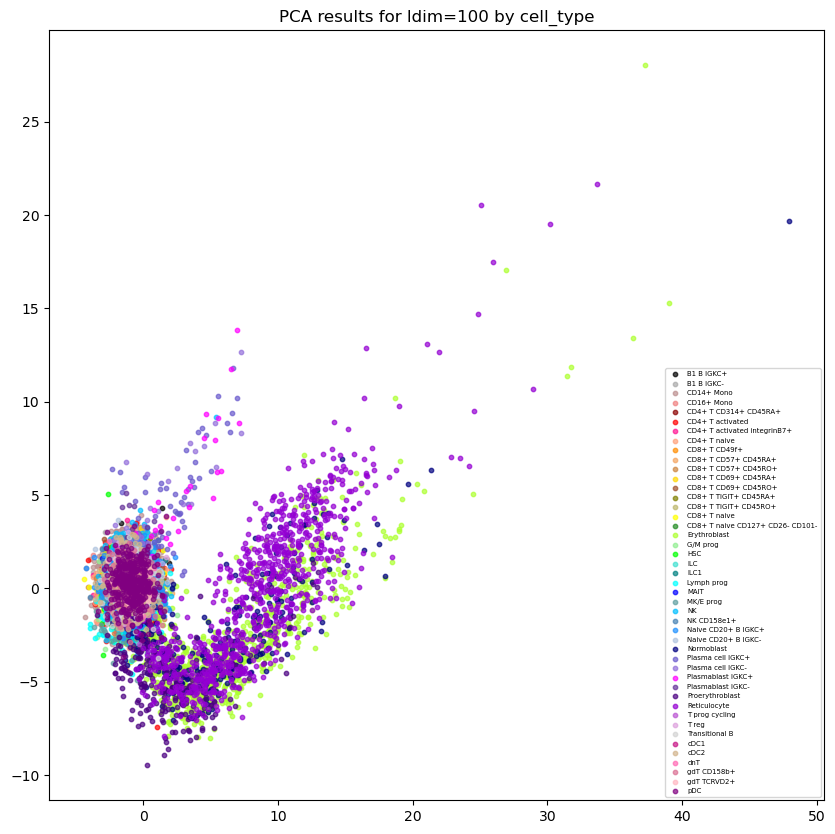

In [68]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld100_hd250_bs32_epo20_PCA_cell_type.png', width = 750, height = 750) 

In [77]:
display(Latex(f"\\newpage"))

<IPython.core.display.Latex object>

* VAE with Exponencial Decoder

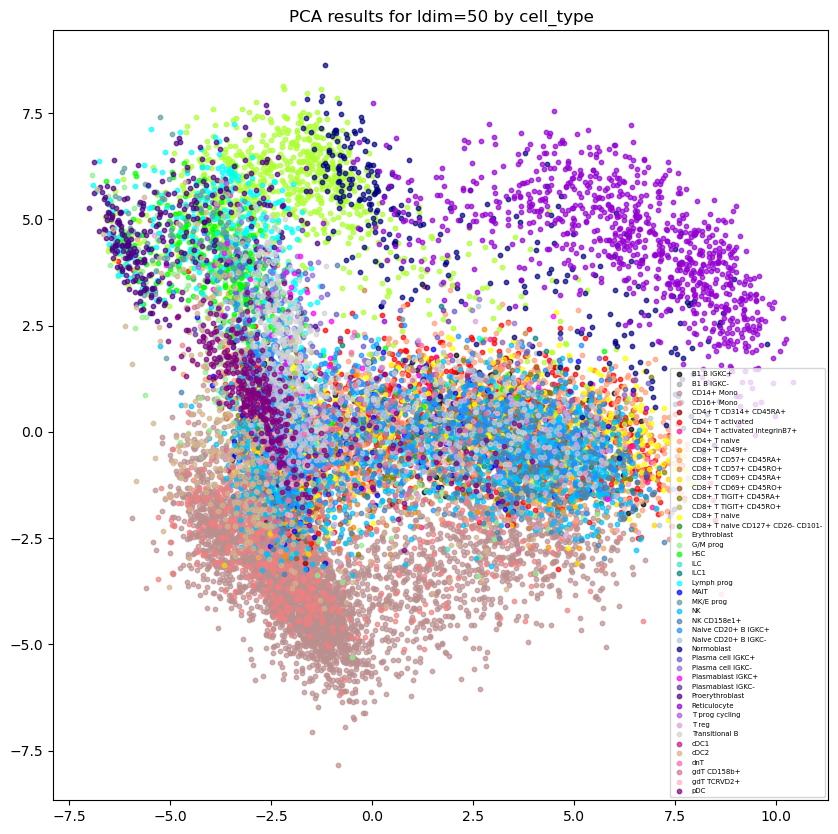

In [56]:
Image(filename='res/custom_decoder/vae_exp_s1.0_b1.0_lr0.005_ld50_hd100_bs32_epo20_PCA_cell_type.png', width = 750, height = 750) 

In the plot for VAE with Exponencial Decoder, we see that the points were better separated in terms of cell type than in the plot for Vanilla VAE. For the Vanilla VAE, only 3 cell types were distinguished from the others, while with the new decoder more cell types were separated. In particular, we can see that the 3 cell types distinguished in the Vanilla VAE (Reticulocyte, Normoblast, Erythroblast - different developmental stages of red blood cells) were even more strongly separated for the new decoder. In addition, in the upper part of the plot for new decoder, additional cell types have been distinguished. In the lower part of the plot, we see a clearly distinguished group of cells belonging to the CD14+ Mono and CD16+ Mono types. Overall, in the graph obtained for the new decoder, we see a much better separation of different cell types than in the case of VAE Vanilla. These results also confirm that VAE with Exponencial Decoder has a better performance on these datasets than Vanilla VAE.

# Adjusting VAE for batch effect #
## Extended PCA plots ##
To investigate whether the batch effect is present in our data, I extend the PCA plots from both Vanilla VAE and VAE with Exponencial Decoder so that the points are coloured by `adata.obs.batch`, `adata.obs.DonorID` and `adata.obs.Site`.

I) `adata.obs.batch`
* Vanilla VAE

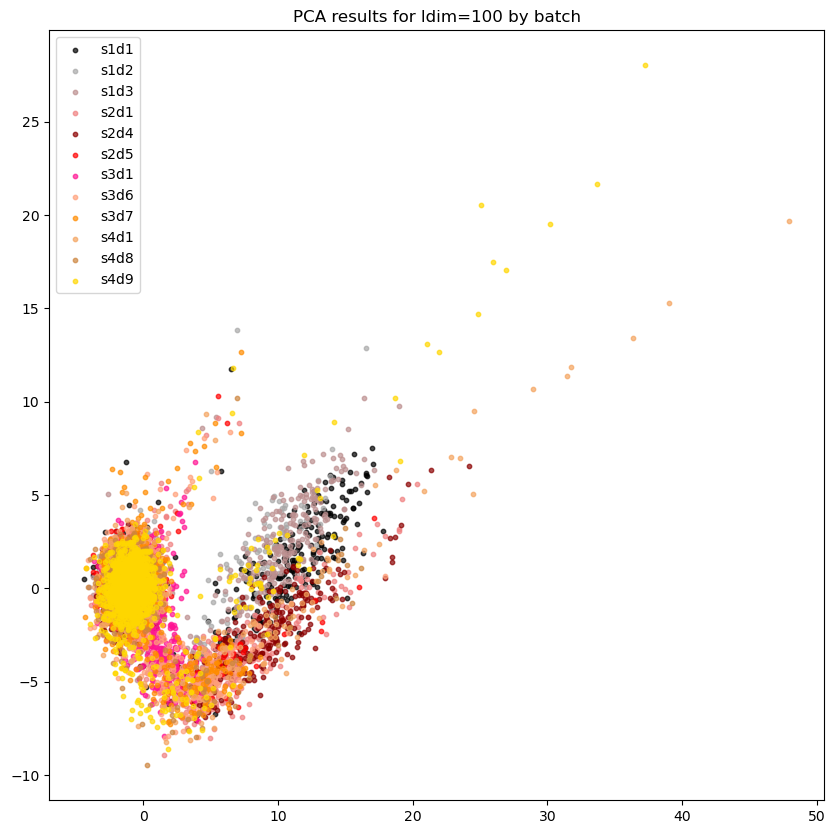

In [60]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld100_hd250_bs32_epo20_PCA_batch.png', width = 750, height = 750) 

In [78]:
display(Latex(f"\\newpage"))

<IPython.core.display.Latex object>

* VAE with Exponencial Decoder

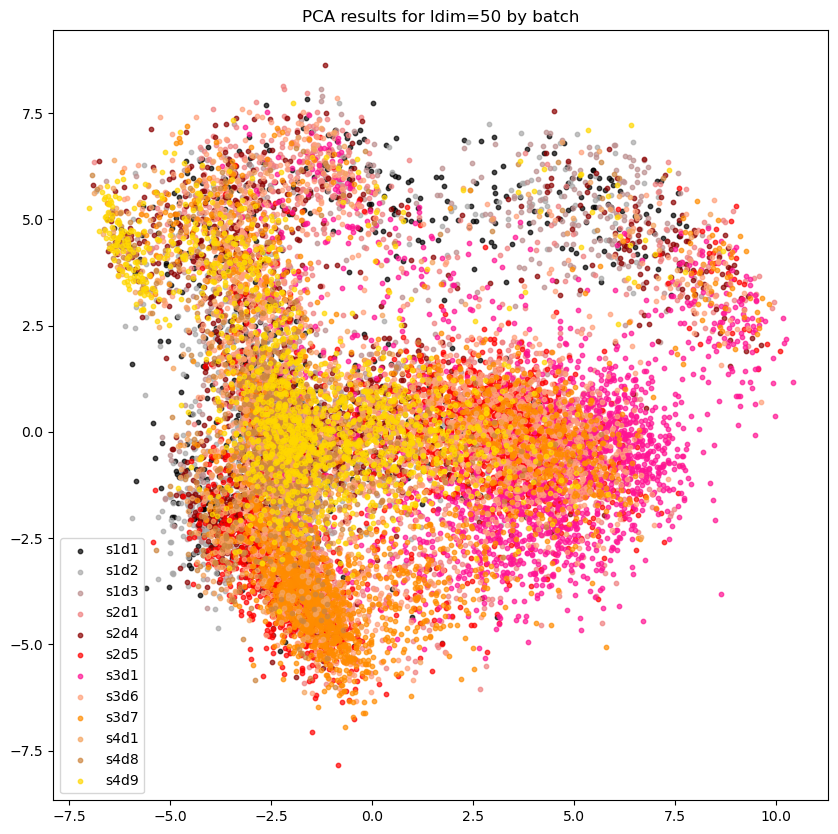

In [61]:
Image(filename='res/custom_decoder/vae_exp_s1.0_b1.0_lr0.005_ld50_hd100_bs32_epo20_PCA_batch.png', width = 750, height = 750) 

In [79]:
display(Latex(f"\\newpage"))

<IPython.core.display.Latex object>

II) `adata.obs.DonorID`
* Vanilla VAE

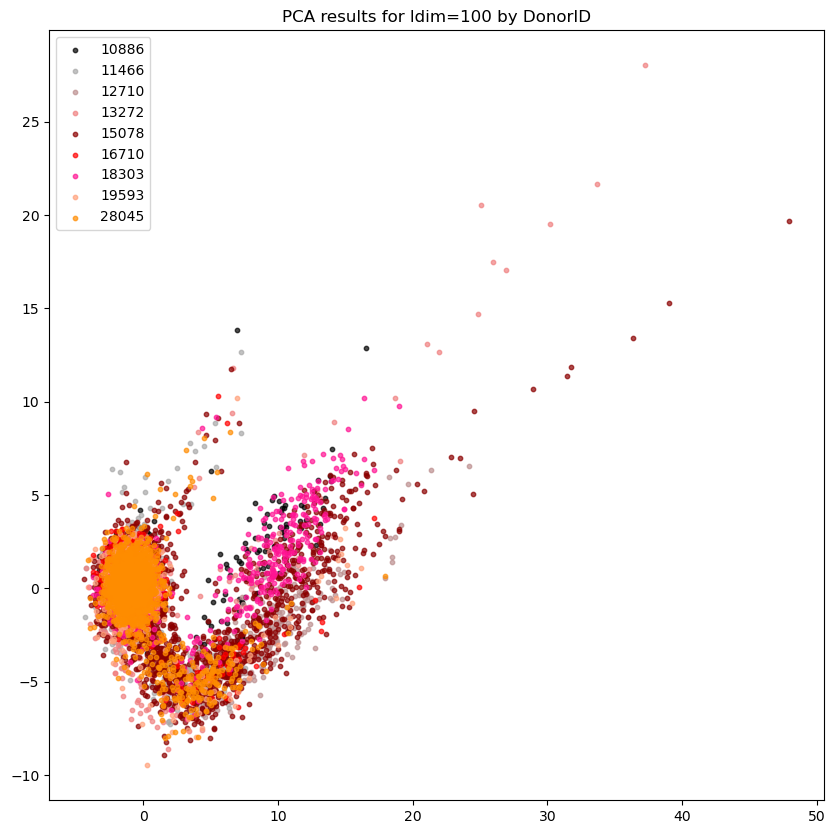

In [62]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld100_hd250_bs32_epo20_PCA_DonorID.png', width = 750, height = 750) 

In [80]:
display(Latex(f"\\newpage"))

<IPython.core.display.Latex object>

* VAE with Exponencial Decoder

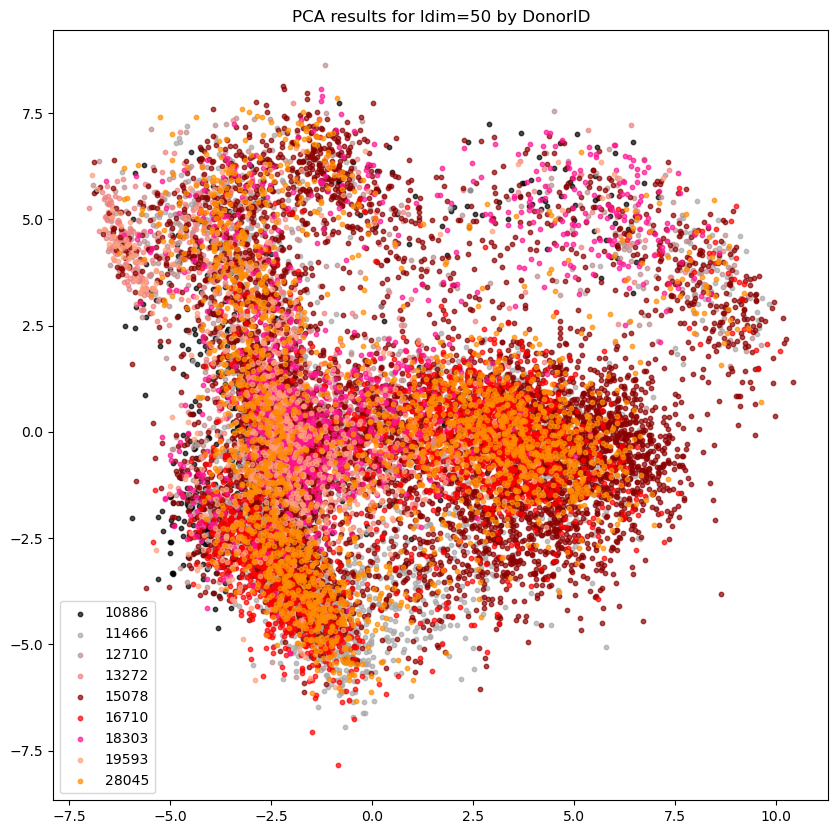

In [63]:
Image(filename='res/custom_decoder/vae_exp_s1.0_b1.0_lr0.005_ld50_hd100_bs32_epo20_PCA_DonorID.png', width = 750, height = 750) 

In [81]:
display(Latex(f"\\newpage"))

<IPython.core.display.Latex object>

III) `adata.obs.Site`
* Vanilla VAE

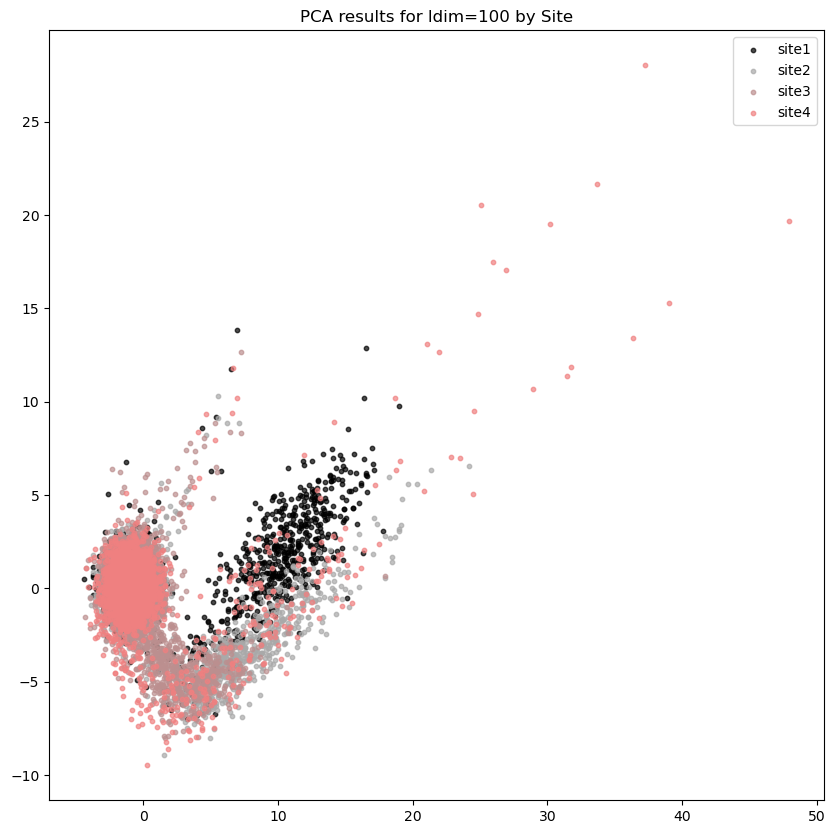

In [64]:
Image(filename='res/vae_vanilla/vae_vanilla_s1.0_b1.0_lr0.0005_ld100_hd250_bs32_epo20_PCA_Site.png', width = 750, height = 750) 

In [82]:
display(Latex(f"\\newpage"))

<IPython.core.display.Latex object>

* VAE with Exponencial Decoder

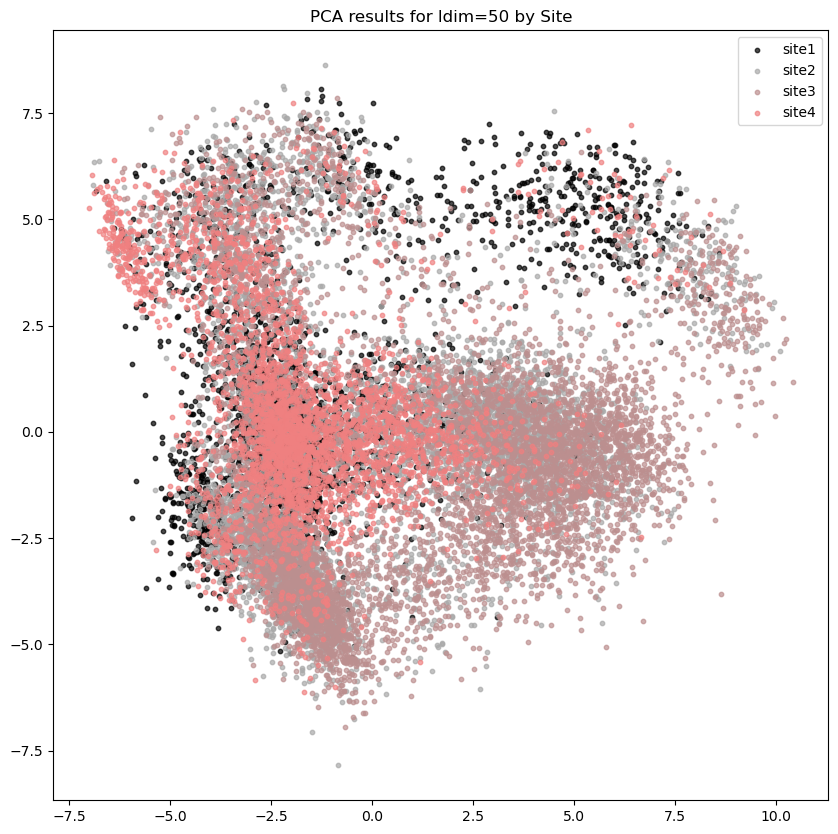

In [65]:
Image(filename='res/custom_decoder/vae_exp_s1.0_b1.0_lr0.005_ld50_hd100_bs32_epo20_PCA_Site.png', width = 750, height = 750) 

Based on the graphs presented, we can conclude that there is no batch effect for any of the characteristics tested in our data. The most separated are the points in terms of patients, but this separation is not strong - no group is clearly separated from the others, all groups overlap in a smaller or larger way. For laboratories and batch, we observe no separation - the groups completely overlap.